Working with the Current Population Survey (CPS) in Python
=====

### Annual Social and Economic Supplement (ASEC)

-----

*Update: May 20, 2018*<br>
*Brian Dew*<br>
*@bd_econ*

The CPS ASEC, also called the March CPS, includes additional questions that cover income, poverty, health insurance coverage, and more. The [raw public use file](http://thedataweb.rm.census.gov/ftp/cps_ftp.html#cpsmarch) is fixed-width format and includes variables described in the associated data dictionary. Unlike the basic monthly CPS, the March CPS records are hierarchical. Person records are nested in family records which are nested in household records. Rows in the raw data that correspond to person records begin with 3. 

This example will look at teachers hours and income in 2006 and 2016 in both the US as a whole and separately among states with large teacher protests in 2018. 

Useful blog posts from Tom Augspurger: 

* [Part 1: Using Python to tackle the CPS](http://tomaugspurger.github.io/tackling%20the%20cps.html)
* [Part 2: Using Python to tackle the CPS](http://tomaugspurger.github.io/tackling%20the%20cps%20%28part%202%29.html)
* [Part 3: Using Python to tackle the CPS](http://tomaugspurger.github.io/tackling%20the%20cps%20%28part%203%29.html)
* [Part 4: Using Python to tackle the CPS](http://tomaugspurger.github.io/tackling%20the%20cps%20%28part%204%29.html)


### Import preliminaries

In [66]:
# Import packages
import pandas as pd
print(f'pandas {pd.__version__}')
import numpy as np
import re, wquantiles

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
mpl.rc('axes', edgecolor='white') # Hide the axes
mpl.rc('figure', figsize=[9, 7])
plt.rc('axes', axisbelow=True)

pandas 0.23.0


### Parameters

In [2]:
files = [('data/asec2007_pubuse_tax2.dat', 'data/cpsmar07.ddf', 2006),
         ('data/asec2017_pubuse.dat', 'data/08ASEC2017_Data_Dict_Full.txt', 2016)]

cpi =  1.19075

### Loop over files and create summary statistics

In [3]:
# Blank dataframe to return with summary statistics
stats = pd.DataFrame()

for file in files:
    # Raw data from Census FTP site
    datafile = file[0]

    # Data dictionary
    dd_txt = file[1]
    dd = open(dd_txt, 'r', encoding='iso-8859-1').read()

    # Retrieve column info from dictionary
    p = re.compile('D (\w+\-?\w+?)\s+(\d{1,2})\s+(\d+)\s+')
    var_key = pd.DataFrame(p.findall(dd), columns=['Var', 'Len', 'Loc'])
    var_key = var_key.apply(pd.to_numeric, errors='ignore')

    # List of variables of interest to be extracted from full file
    s = ['A_AGE', 'A_SEX', 'MARSUPWT', 'PRECORD', 'WEWKRS', 'WSAL_VAL', 
         'HRSWK', 'GESTFIPS', 'PEIOOCC', 'WKSWORK', 'A_CLSWKR',
         'PEMOMTYP', 'PEDADTYP', 'ERN_VAL', 'A-AGE', 'A-SEX', 'WSAL-VAL',
         'A-CLSWKR', 'ERN-VAL']
    s_key = var_key[var_key['Var'].isin(s)]

    # Read raw fwf file
    data = pd.read_fwf(datafile, header=None, names=list(s_key.Var),
                     colspecs=list(zip(s_key.Loc-1, s_key.Loc + s_key.Len-1)))

    # Calculate annual hours (weeks * (hours/week))
    data['ANN_HRS'] = data['WKSWORK'] * data['HRSWK']
    
    # States filled in (blank in early year person records)
    if file[2] == 2006:
        data['GESTFIPS'] = data['GESTFIPS'].replace(to_replace=0, method='ffill')
        # Rename columns to later year variable format
        data.columns = data.columns.str.replace('-', '_')
        
    if file[2] == 2016:
        data['State'] = [d[1]['GESTFIPS'] if d[1]['PRECORD'] == 1 else 0 for d in data.iterrows()]
        data['GESTFIPS'] = data['State'].replace(to_replace=0, method='ffill')

    # Keep person records with wage data & 80+ hours worked 
    df = data.loc[(data['PRECORD'] == 3)]

    # Convert weight variable to float
    df['MARSUPWT'] = df['MARSUPWT'].astype(float)

    # Keep only observations with a weight > 0
    df = df[df['MARSUPWT'] > 0]
    
    # Hourly wage
    df['HRLY_WAGE'] = df['ERN_VAL'] / df['ANN_HRS']

    # Identify public school teachers working 3/4 year or more
    pt = df[(df['PEIOOCC'].between(2200,2340)) & 
            (df['A_CLSWKR'].between(3,5)) & 
            (df['ANN_HRS'] >= 1365) & 
            (df['A_AGE'].between(25, 54))]

    # Identify subset in WV, OK, AZ, KY, NC, and CO
    pt2 = pt[pt['GESTFIPS'].isin([54, 40, 4, 21, 37, 8])]

    for g in [(pt, 'All States'), (pt2, 'Active States')]:
        for p in [0.1, 0.25, 0.5, 0.75, 0.9]:
            if file[2] == 2006:
                stats.at[f'p{int(p * 100)}, wage', f'{g[1]}, {file[2]}'] = round(wquantiles.quantile(
                    g[0]['ERN_VAL'], g[0]['MARSUPWT'], p) * cpi, 2)
            else:
                stats.at[f'p{int(p * 100)}, wage', f'{g[1]}, {file[2]}'] = round(wquantiles.quantile(
                    g[0]['ERN_VAL'], g[0]['MARSUPWT'], p), 2)
        tmp = g[0][g[0]['ERN_VAL'] > 0]
        if file[2] == 2006:
            stats.at[f'Mean', f'{g[1]}, {file[2]}'] = round(np.average(
                     tmp['ERN_VAL'], weights=tmp['MARSUPWT']) * 1.19075, 2)
        else:
            stats.at[f'Mean', f'{g[1]}, {file[2]}'] = round(np.average(
                     tmp['ERN_VAL'], weights=tmp['MARSUPWT']), 2)
            
        stats.at['n', f'{g[1]}, {file[2]}'] = len(g[0])
        
        stats.at['Weighed n', f'{g[1]}, {file[2]}'] = round(g[0]['MARSUPWT'].sum() / 100.0, -2)

C:\Users\BDew\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [18]:
to_plot = stats.iloc[:-2].T.sort_index(ascending=True)
stats

,"All States, 2006","Active States, 2006","All States, 2016","Active States, 2016"
"p10, wage",10.52,9.23,12.02,11.97
"p25, wage",17.01,14.47,17.50,15.64
"p50, wage",22.90,20.04,23.60,20.51
"p75, wage",31.49,26.20,31.25,25.67
"p90, wage",40.93,37.95,43.27,34.98
Mean,24.47,21.38,27.11,24.07
n,2594.00,222.00,2191.00,215.00
Weighed n,3570300.00,330700.00,3577900.00,344500.00


In [20]:
to_plot

,"p10, wage","p25, wage","p50, wage","p75, wage","p90, wage",Mean
"Active States, 2006",9.23,14.47,20.04,26.20,37.95,21.38
"Active States, 2016",11.97,15.64,20.51,25.67,34.98,24.07
"All States, 2006",10.52,17.01,22.90,31.49,40.93,24.47
"All States, 2016",12.02,17.50,23.60,31.25,43.27,27.11


In [39]:
plt.setp(bp['boxes'], color='blue')
plt.setp(bp['whiskers'], color='blue')

[None, None, None, None, None, None, None, None]

C:\Users\BDew\Anaconda3\lib\site-packages\matplotlib\patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"
C:\Users\BDew\Anaconda3\lib\site-packages\matplotlib\patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"
C:\Users\BDew\Anaconda3\lib\site-packages\matplotlib\patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"
C:\Users\BDew\Anaconda3\lib\site-packages\matplotlib\patches.py:83: UserWarning: Setting the 'color' property will overridethe edgecolor or facecolor properties. 
  warnings.warn("Setting the 'color' property will override"


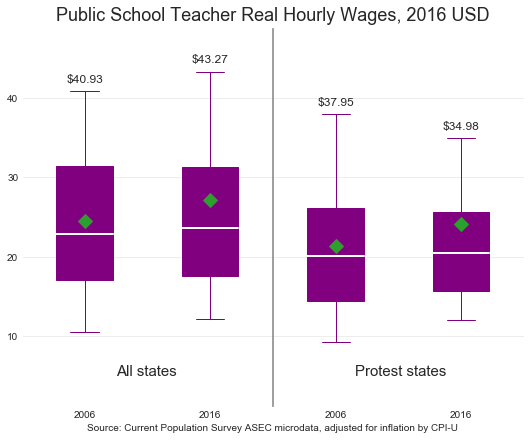

In [92]:
plt.setp(bp['boxes'], color='blue')
plt.setp(bp['whiskers'], color='blue')

item = {}

item["label"] = '2006' # not required
item["mean"] = 24.47 # not required
item["med"] = 22.90
item["q1"] = 17.01
item["q3"] = 31.49
item["whislo"] = 10.52 # required
item["whishi"] = 40.93 # required
item["fliers"] = [] # required if showfliers=True
item['facecolor'] = 'red'

item2 = {}

item2["label"] = '2016' # not required
item2["mean"] = 27.11 # not required
item2["med"] = 23.60
item2["q1"] = 17.50
item2["q3"] = 31.25
item2["whislo"] = 12.2 # required
item2["whishi"] = 43.27 # required
item2["fliers"] = [] # required if showfliers=True

item3 = {}

item3["label"] = '2006' # not required
item3["mean"] = 21.38 # not required
item3["med"] = 20.04
item3["q1"] = 14.47
item3["q3"] = 26.20
item3["whislo"] = 9.23 # required
item3["whishi"] = 37.95 # required
item3["fliers"] = [] # required if showfliers=True

item4 = {}

item4["label"] = '2016' # not required
item4["mean"] = 24.07 # not required
item4["med"] = 20.51
item4["q1"] = 15.64
item4["q3"] = 25.67
item4["whislo"] = 11.97 # required
item4["whishi"] = 34.98 # required
item4["fliers"] = [] # required if showfliers=True

stats = [item, item2, item3, item4]

boxprops = dict(color='purple')
medianprops = dict(linewidth=2, color='white')
whiskerprops = dict(color='purple')
capprops = dict(color='purple')
meanpointprops = dict(marker='D', markersize=10)

fig, axes = plt.subplots(1, 1)
axes.bxp(stats, patch_artist=True, showmeans=True, 
         medianprops=medianprops, boxprops=boxprops,
         whiskerprops=whiskerprops, capprops=capprops,
         meanprops=meanpointprops)
axes.set_title('Public School Teacher Real Hourly Wages, 2016 USD', fontsize=18)
axes.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)
axes.set_ylim(1, 49)
plt.axvline(x=2.5, color='gray')
plt.annotate('All states', (1.25, 5), size=15)

plt.annotate('Protest states', (3.15, 5), size=15)

plt.annotate('$40.93', (1, 42), size=12, ha='center')
plt.annotate('$43.27', (2, 44.5), size=12, ha='center')
plt.annotate('$37.95', (3, 39), size=12, ha='center')
plt.annotate('$34.98', (4, 36), size=12, ha='center')

plt.xlabel('Source: Current Population Survey ASEC microdata, adjusted for inflation by CPI-U')

plt.savefig('teacherpay.png', bbox_inches='tight', dpi=200)